In [2]:
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x / 1000))


wandb.login()
api = wandb.Api()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yw580 (pico-lm). Use `wandb login --relogin` to force relogin


In [3]:
tiny_lora = api.run("pico-lm/pico-relora/ixdq4sof")
small_lora = api.run("pico-lm/pico-relora/a8nvp3mi")
tiny_base = api.run("pico-lm/pico-relora/e8rwqdwk")
small_base = api.run("pico-lm/pico-relora/evrk6fbj")

In [4]:
data = {
    "lora": {
        "tiny": pd.DataFrame(tiny_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_lora.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
    "base": {
        "tiny": pd.DataFrame(tiny_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
        "small": pd.DataFrame(small_base.scan_history())
        .replace("NaN", np.nan, inplace=False)
        .infer_objects(copy=False),
    },
}

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_95586/3679100403.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)
/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_95586/3679100403.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("NaN", np.nan, inplace=False)


In [5]:
def get_across_ranges(
    df: pd.DataFrame, metric_name: str, step_mod: int = 1, step_mod_offset: int = 0, *ranges
):
    if not ranges:
        ranges = (range(12),)
    combos = product(*ranges)
    df = df.drop_duplicates(subset=["_step"], inplace=False)
    mask = df["_step"] % step_mod == step_mod_offset
    df = df[mask]
    x = [df[metric_name.format(*combo)].replace("NaN", np.nan).to_numpy() for combo in combos]
    return np.column_stack(x)

In [6]:
STEP_MOD = 2_000

In [7]:
def _get_per_data():
    for mod in ("swiglu.w_2", "ov_circuit"):
        for t in data:
            for s in data[t]:
                metr_str = (
                    "per_val/_forward_module.module.layers.{}"
                    + f".{mod}{'.base' if t == 'lora' else ''}.weights"
                )
                val = get_across_ranges(
                    data[t][s], metr_str, step_mod=2_000, step_mod_offset=0 if t == "base" else 100
                )
                for ckp_id, ckp in enumerate(val):
                    for lay_id, layer_val in enumerate(ckp):
                        yield (
                            r"OV Circuit" if "ov" in mod else r"Swiglu $W_2$",
                            rf"\texttt{{pico-{'decoder' if t == 'base' else 'relora'}}}",
                            s,
                            int(ckp_id * 2),
                            lay_id,
                            layer_val,
                        )


per_data = pd.DataFrame(
    _get_per_data(),
    columns=["Component", "Model", "Scale", "Step", "Layer", "PER"],
)

In [8]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16
SUP_LABEL_SIZE = 18

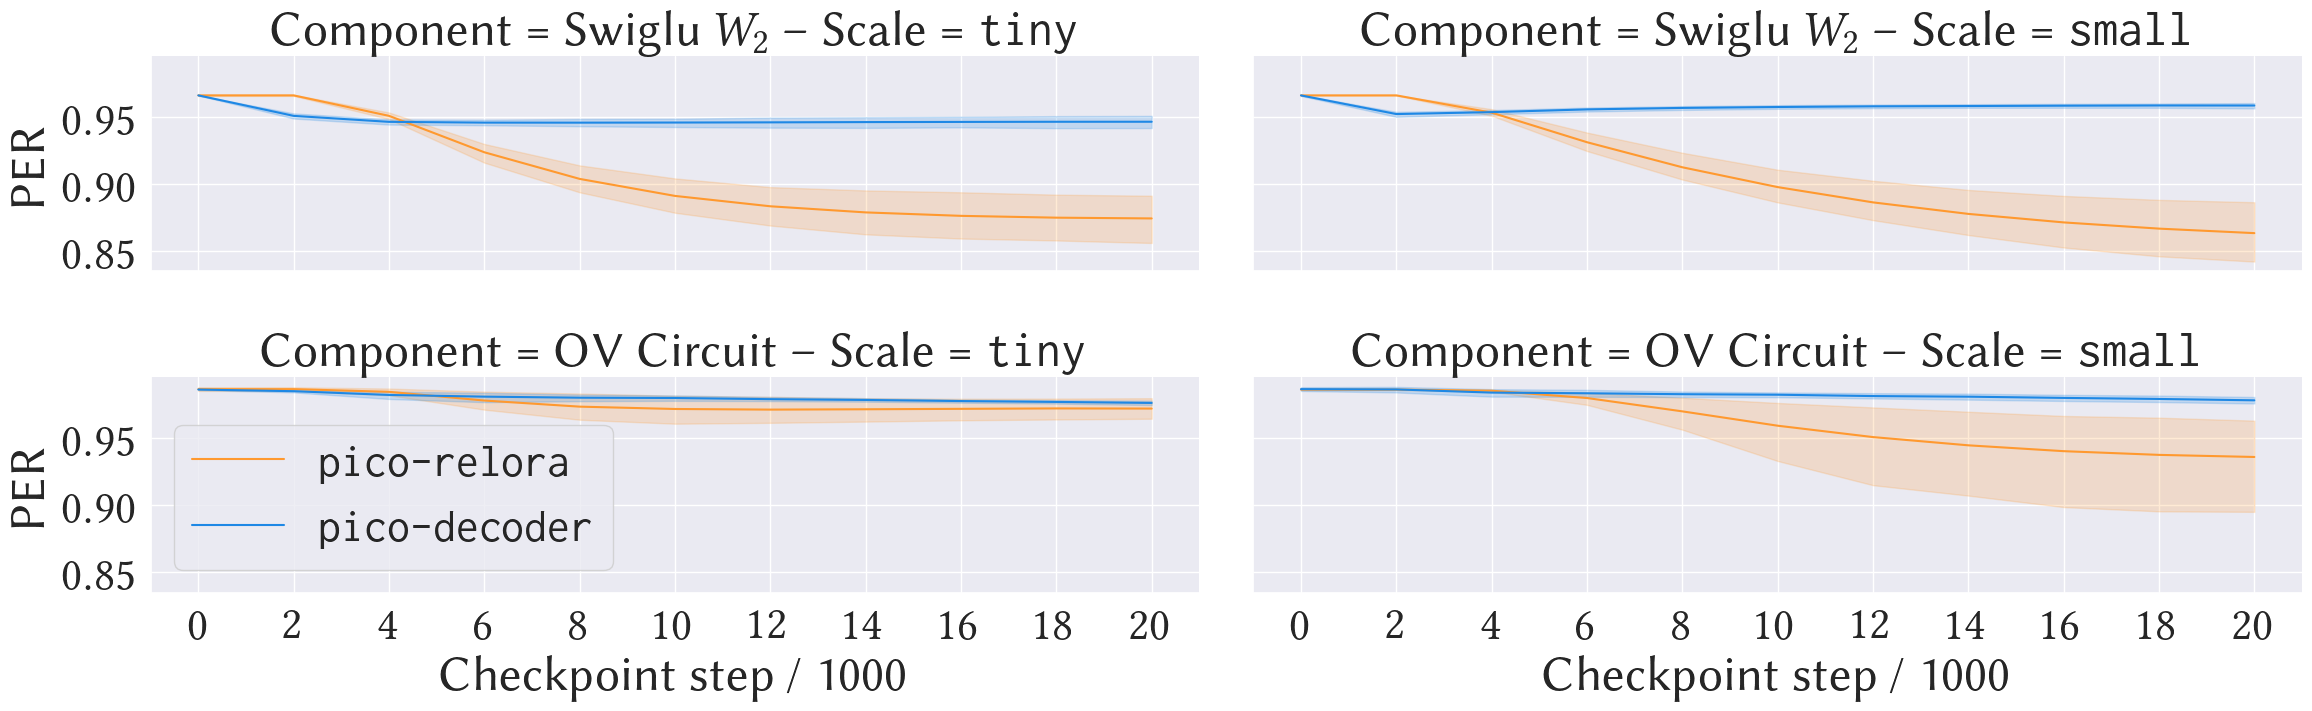

In [10]:
colors = ["#1E88E5", "#FF992F"]
models = sorted(per_data["Model"].unique().tolist())
palette = dict(zip(models, colors))

dodge = 0.4
size = 8
font_scale = 3

sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})

g = sns.FacetGrid(
    data=per_data,
    col="Scale",
    row="Component",
    height=4,
    aspect=3,
    sharey=True,
    sharex=True,
    margin_titles=False,
)

g.set_titles(template=r"Component = {row_name} -- Scale = \texttt{{{col_name}}}")


g.map_dataframe(sns.lineplot, x="Step", y="PER", hue="Model", palette=palette, markers=["s", "o"])

g.set_axis_labels("Checkpoint step / 1000", "PER")

for idx, ax in enumerate(g.axes.flat):
    steps = per_data["Step"].unique()
    ax.set_xticks(steps)
    if idx == 2:
        ax.legend(bbox_to_anchor=(0, 0), loc="lower left")

plt.savefig("../graphs/per.pdf", bbox_inches="tight")
plt.show()

# OV circuit fst vs last

In [11]:
per_split = per_data.copy()
per_split["Split"] = np.where(per_data["Layer"] > 5, "Last Six", "First Six")


def sjoin(*args):
    return f"{args[0].Component} ({args[0].Split})"


per_split["Component"] = per_split[["Component", "Split"]].astype(str).agg(sjoin, axis=1)

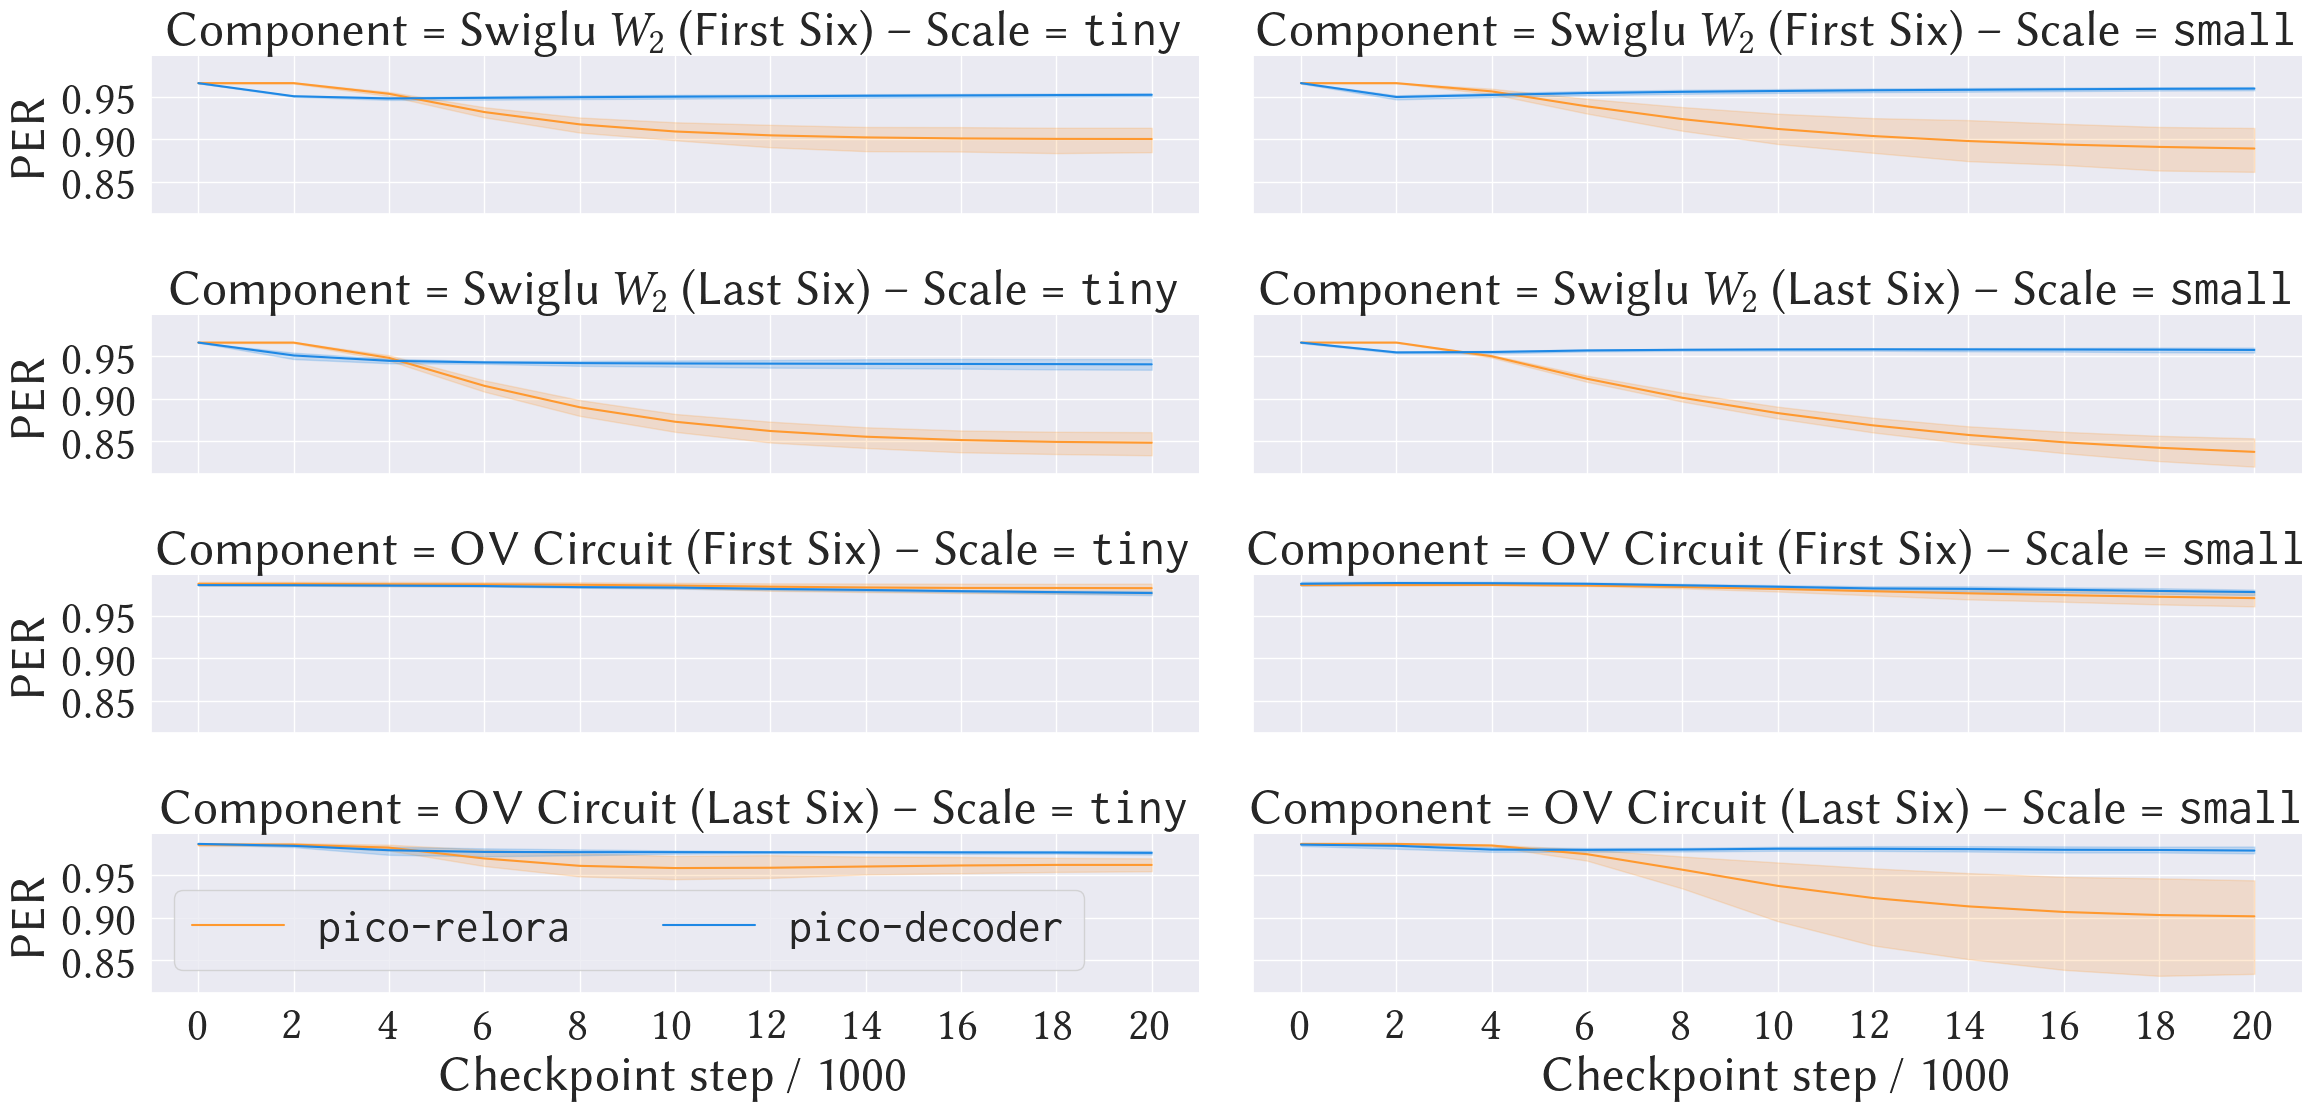

In [14]:
colors = ["#1E88E5", "#FF992F"]
models = sorted(per_split["Model"].unique().tolist())
palette = dict(zip(models, colors))

dodge = 0.4
size = 8
font_scale = 3

sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})

g = sns.FacetGrid(
    data=per_split,
    col="Scale",
    row="Component",
    height=3,
    aspect=4,
    sharey=True,
    sharex=True,
    margin_titles=False,
)

g.set_titles(template=r"Component = {row_name} -- Scale = \texttt{{{col_name}}}")


g.map_dataframe(sns.lineplot, x="Step", y="PER", hue="Model", palette=palette, markers=["s", "o"])

g.set_axis_labels("Checkpoint step / 1000", "PER")

for idx, ax in enumerate(g.axes.flat):
    steps = per_split["Step"].unique()
    ax.set_xticks(steps)
    if idx == 6:
        ax.legend(bbox_to_anchor=(0, 0), loc="lower left", ncols=2)

plt.savefig("../graphs/per-fst-lst.pdf", bbox_inches="tight")
plt.show()